In [118]:
import os
if len(os.getcwd().split('/')) != 8:
    os.chdir('..')

print(os.getcwd())

/Users/rohaan/Desktop/storage/RIT/federated_learning_lab/federated_learning


In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import json
import numpy as np
import random
import matplotlib.pyplot as plt

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [120]:
def set_seed(seed):
    torch.manual_seed(seed)           # For CPU
    torch.cuda.manual_seed(seed)      # For CUDA (if using GPU)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    np.random.seed(seed)              # For NumPy
    random.seed(seed)                 # For Python's built-in random
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False     # Turn off optimization for reproducibility

In [121]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 as required by LeNet-5
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(f"Datasets:\n\t-> TRAIN: {'available' if train_dataset else 'N/A'}\n\t-> TEST: {'available' if train_dataset else 'N/A'}")

Datasets:
	-> TRAIN: available
	-> TEST: available


In [122]:
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

print(f"Datasets:\n\t-> TRAIN: {len(train_loader.dataset)} samples\n\t-> TEST: {len(test_loader.dataset)} samples")

Datasets:
	-> TRAIN: 60000 samples
	-> TEST: 10000 samples


In [123]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # kernel_size aka filter size
        # out_channels aka number of filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = torch.tanh(x) 
        # layer 2
        x = nn.functional.avg_pool2d(input=x, kernel_size=2, stride=2)
        x = torch.tanh(x) 
        # layer 3
        x = self.conv2(x)
        x = torch.tanh(x) 
        # layer 4
        x = nn.functional.avg_pool2d(input=x, kernel_size=2, stride=2)
        x = torch.tanh(x) 
        # layer 5
        x = self.conv3(x)
        x = torch.tanh(x) 
        # layer 6
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.tanh(x) 
        # output layer
        x = self.fc2(x)
        # x = nn.functional.softmax(x, dim=1)  # remove softmax if using crossEntropy since it applies the softmax function too
    
        return x

In [124]:
def get_batch_by_idx(train_loader, batch_idx):
    # Calculate start and end indices for the batch
    start_idx = batch_idx * train_loader.batch_size
    end_idx = start_idx + train_loader.batch_size
    
    if end_idx > len(train_loader.dataset):
        end_idx = len(train_loader.dataset)

    # Fetch the data and target tensors for that batch
    data_list, target_list = [], []
    for idx in range(start_idx, end_idx):
        data, target = train_loader.dataset[idx]
        data_list.append(data)
        target_list.append(target)

    # Stack the list into a batch
    data_batch = torch.stack(data_list)
    target_batch = torch.tensor(target_list)

    return data_batch, target_batch

In [125]:
def initialize_model(seed=42):
    set_seed(seed)
    model = LeNet5()
    return model

In [126]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

    return avg_test_loss, accuracy

In [127]:
def flatten_vector(state_dict):
    flat_vector = []
    shapes = {}

    for name, tensor in state_dict.items():
        flattened_tensor = tensor.view(-1)  # Flatten the tensor into a 1D vector
        flat_vector.append(flattened_tensor)
        shapes[name] = tensor.shape  # Store the original shape

    # Concatenate all flattened tensors into a single 1D vector
    flat_vector = torch.cat(flat_vector)

    return flat_vector, shapes

In [128]:
def vector_to_state_dict(flat_vector, shapes):
    reconstructed_state_dict = {}
    current_index = 0

    for name, shape in shapes.items():
        # Calculate the number of elements in the tensor
        num_elements = torch.prod(torch.tensor(shape))
        # Extract the corresponding portion from the flat vector
        flattened_tensor = flat_vector[current_index:current_index + num_elements]
        # Reshape the 1D tensor back to its original shape
        tensor = flattened_tensor.view(shape)
        # Add the tensor back to the state_dict
        reconstructed_state_dict[name] = tensor
        # Update the current index
        current_index += num_elements

    return reconstructed_state_dict

In [129]:
class GA:
    def __init__(
        self, seed: int, d: int, q: int, device: torch.device = torch.device("cpu")
    ) -> None:
        self.seed = seed
        self.d = d
        self.q = q
        self.device = device
        torch.manual_seed(self.seed)

        print(f"GA initialized with seed={seed}, d={d}, q={q}, device={device}")

    def G(self) -> torch.Tensor:
        return torch.rand(self.d, self.q).to(self.device)

    def w(self, delta: torch.Tensor) -> torch.Tensor:
        GT = self.G().t()  # Transpose the tensor
        return torch.matmul(GT, delta) / self.q

    def delta(self, w: torch.Tensor) -> torch.Tensor:
        return torch.matmul(self.G(), w)

In [130]:
def normalize(tensor: torch.Tensor, min_val: float = 0.0, max_val: float = 1.0) -> torch.Tensor:
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    
    # Scale tensor to range [0, 1]
    normalized_tensor = (tensor - tensor_min) / (tensor_max - tensor_min)
    
    # Scale to desired range [min_val, max_val]
    normalized_tensor = normalized_tensor * (max_val - min_val) + min_val
    
    return normalized_tensor

In [131]:
def train(model, train_loader, optimizer, criterion, batch_idx):
    model.train()
    train_loss = 0
    
    # current weights
    w_t = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
    
    data, target = get_batch_by_idx(train_loader, batch_idx)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    
    # new weights
    w_t_plus_1 = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
    updates = {
        name: (w_t[name] - w_t_plus_1[name])
        for name in w_t_plus_1}
    
    return updates, loss

In [132]:
def normalize(tensor: torch.Tensor, min_val: float = 0.0, max_val: float = 1.0) -> torch.Tensor:
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    
    # Scale tensor to range [0, 1]
    normalized_tensor = (tensor - tensor_min) / (tensor_max - tensor_min)
    
    # Scale to desired range [min_val, max_val]
    normalized_tensor = normalized_tensor * (max_val - min_val) + min_val
    
    return normalized_tensor

In [133]:
train_losses = []
test_losses = []
accuracies = []
deltas = []
gws = []
approximation_errors = []

rounds = len(train_loader)
print(f"Rounds: {rounds}, Batch Size: {train_loader.batch_size}")

model = initialize_model(seed=1829).to(device)
lr = 0.01

for round in range(1, 1 + rounds):
    print(f"Running round {round}/{rounds}")

    updates, loss = train(
        model=model,
        train_loader=train_loader,
        optimizer=optim.Adam(model.parameters(), lr=lr),
        criterion=nn.CrossEntropyLoss(),
        batch_idx=round - 1,
    )

    # apply GA
    updates_flattened, shapes = flatten_vector(updates)

    seed = random.randint(0, 100)
    ga = GA(seed=seed, d=len(updates_flattened), q=int(1e3), device=device)
    w = ga.w(delta=updates_flattened)
    gw = ga.delta(w=w)

    # Normalize
    gw = normalize(
        tensor=gw, min_val=updates_flattened.min(), max_val=updates_flattened.max()
    )

    # calculate error
    error = updates_flattened - gw
    l2_norm_error = torch.norm(error, p=2)
    approximation_errors.append(l2_norm_error)

    # apply approximated updates
    curr_weights_dict = {
        name: weights.clone().detach().cpu()
        for name, weights in model.state_dict().items()
    }
    curr_weights, _ = flatten_vector(curr_weights_dict)
    new_weights = curr_weights + gw

    new_weights_dict = vector_to_state_dict(flat_vector=new_weights, shapes=shapes)

    model.load_state_dict(state_dict=new_weights_dict)

    avg_test_loss, accuracy = test(
        model, device, test_loader, criterion=nn.CrossEntropyLoss()
    )

    # for plotting
    train_losses.append(float(loss))
    test_losses.append(avg_test_loss)
    accuracies.append(accuracy)
    deltas.append(updates_flattened)
    gws.append(gw)

Rounds: 235, Batch Size: 256
Running round 1/235
GA initialized with seed=45, d=61706, q=1000, device=cpu

Test set: Average loss: 0.0020, Accuracy: 4659/10000 (47%)

Running round 2/235
GA initialized with seed=90, d=61706, q=1000, device=cpu

Test set: Average loss: 0.0015, Accuracy: 4787/10000 (48%)

Running round 3/235
GA initialized with seed=20, d=61706, q=1000, device=cpu

Test set: Average loss: 0.0016, Accuracy: 4398/10000 (44%)

Running round 4/235
GA initialized with seed=22, d=61706, q=1000, device=cpu

Test set: Average loss: 0.0013, Accuracy: 5833/10000 (58%)

Running round 5/235
GA initialized with seed=32, d=61706, q=1000, device=cpu

Test set: Average loss: 0.0013, Accuracy: 5824/10000 (58%)

Running round 6/235
GA initialized with seed=44, d=61706, q=1000, device=cpu

Test set: Average loss: 0.0011, Accuracy: 6134/10000 (61%)

Running round 7/235
GA initialized with seed=20, d=61706, q=1000, device=cpu

Test set: Average loss: 0.0010, Accuracy: 6634/10000 (66%)

Runni

In [147]:
control_accuracies = []
control_train_losses = []
control_test_losses = []

model = initialize_model(seed=42).to(device)
lr = 0.01

for round in range(1, 1 + rounds):
    print(f"Running round {round}/{rounds}")

    updates, loss = train(
        model=model,
        train_loader=train_loader,
        optimizer=optim.Adam(model.parameters(), lr=lr),
        criterion=nn.CrossEntropyLoss(),
        batch_idx=round - 1,
    )

    avg_test_loss, accuracy = test(
        model, device, test_loader, criterion=nn.CrossEntropyLoss()
    )

    # for plotting
    train_losses.append(float(loss))
    test_losses.append(avg_test_loss)
    control_accuracies.append(accuracy)

Running round 1/235

Test set: Average loss: 0.0020, Accuracy: 4698/10000 (47%)

Running round 2/235

Test set: Average loss: 0.0015, Accuracy: 4824/10000 (48%)

Running round 3/235

Test set: Average loss: 0.0017, Accuracy: 4306/10000 (43%)

Running round 4/235

Test set: Average loss: 0.0013, Accuracy: 5877/10000 (59%)

Running round 5/235

Test set: Average loss: 0.0013, Accuracy: 5799/10000 (58%)

Running round 6/235

Test set: Average loss: 0.0011, Accuracy: 6138/10000 (61%)

Running round 7/235

Test set: Average loss: 0.0011, Accuracy: 6551/10000 (66%)

Running round 8/235

Test set: Average loss: 0.0009, Accuracy: 6965/10000 (70%)

Running round 9/235

Test set: Average loss: 0.0009, Accuracy: 6772/10000 (68%)

Running round 10/235

Test set: Average loss: 0.0008, Accuracy: 7533/10000 (75%)

Running round 11/235

Test set: Average loss: 0.0007, Accuracy: 7574/10000 (76%)

Running round 12/235

Test set: Average loss: 0.0007, Accuracy: 7335/10000 (73%)

Running round 13/235

Tes

In [148]:
import pandas as pd
import seaborn as sns
import pandas as pd

# Create a DataFrame
data = {
    'Round': list(range(1, rounds + 1)),
    'MNIST + GA + Norm': accuracies,
    'MNIST' : control_accuracies
    }

df_accuracies = pd.DataFrame(data)

df_accuracies


,Round,MNIST + GA + Norm,MNIST
0,1,46.59,46.98
1,2,47.87,48.24
2,3,43.98,43.06
3,4,58.33,58.77
4,5,58.24,57.99
...,...,...,...
230,231,96.03,94.89
231,232,95.65,95.99
232,233,95.90,95.63
233,234,95.26,95.09


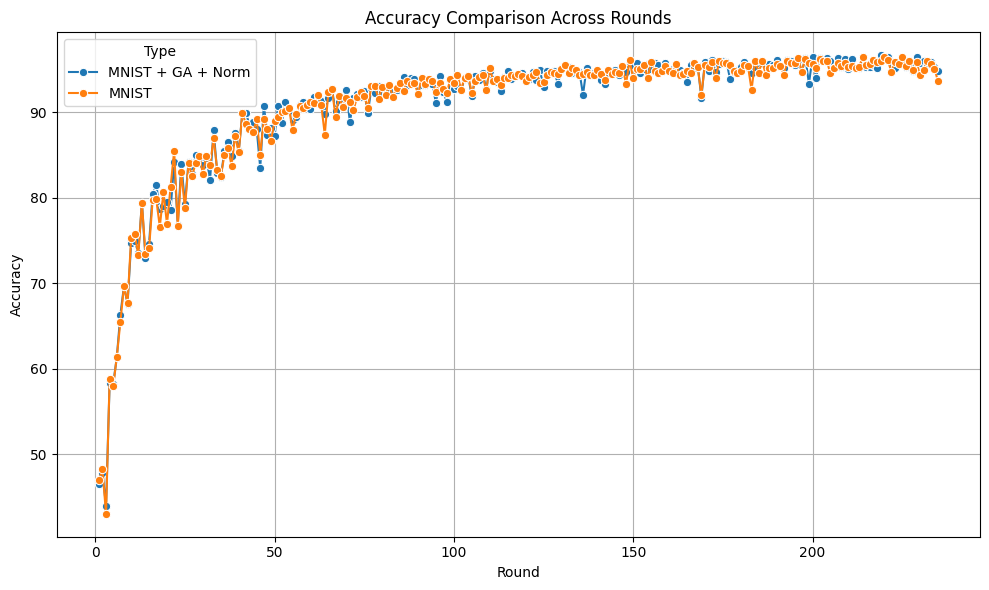

In [150]:
# Melt the DataFrame for easier plotting
df_accuracies_melted = df_accuracies.melt(id_vars='Round', var_name='Type', value_name='Accuracy')

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Round', y='Accuracy', hue='Type', data=df_accuracies_melted, marker='o')

# Customize plot
plt.title('Accuracy Comparison Across Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend(title='Type')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(data = {
    'delta_1' : [float(x) for x in deltas[0]],
    'delta_2' : [float(x) for x in deltas[1]],
    'delta_3' : [float(x) for x in deltas[2]],
    'Gw_1' : [float(x) for x in gws[0]],
    'Gw_2' : [float(x) for x in gws[1]],
    'Gw_3' : [float(x) for x in gws[2]]
})

df

,delta_1,delta_2,delta_3,Gw_1,Gw_2,Gw_3
0,0.009996,0.01,-0.01,-0.001479,0.003568,-0.006978
1,-0.010000,0.01,-0.01,0.001121,0.003613,0.005576
2,-0.010000,0.01,-0.01,0.001943,0.005292,-0.000439
3,-0.010000,-0.01,-0.01,0.001261,0.002231,0.001526
4,-0.010000,-0.01,-0.01,0.003180,0.003495,0.001882
...,...,...,...,...,...,...
61701,0.010000,-0.01,-0.01,0.002694,-0.000824,-0.001341
61702,0.010000,0.01,-0.01,-0.000344,0.001734,-0.001949
61703,-0.010000,-0.01,0.01,-0.000416,-0.000577,0.003230
61704,0.010000,0.01,-0.01,-0.003411,-0.001825,0.000873


/var/folders/66/p1j5g0w12bx003hgq7kkdg5w0000gn/T/ipykernel_18009/1928139607.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variable', y='value', data=df_melted, palette=palette)


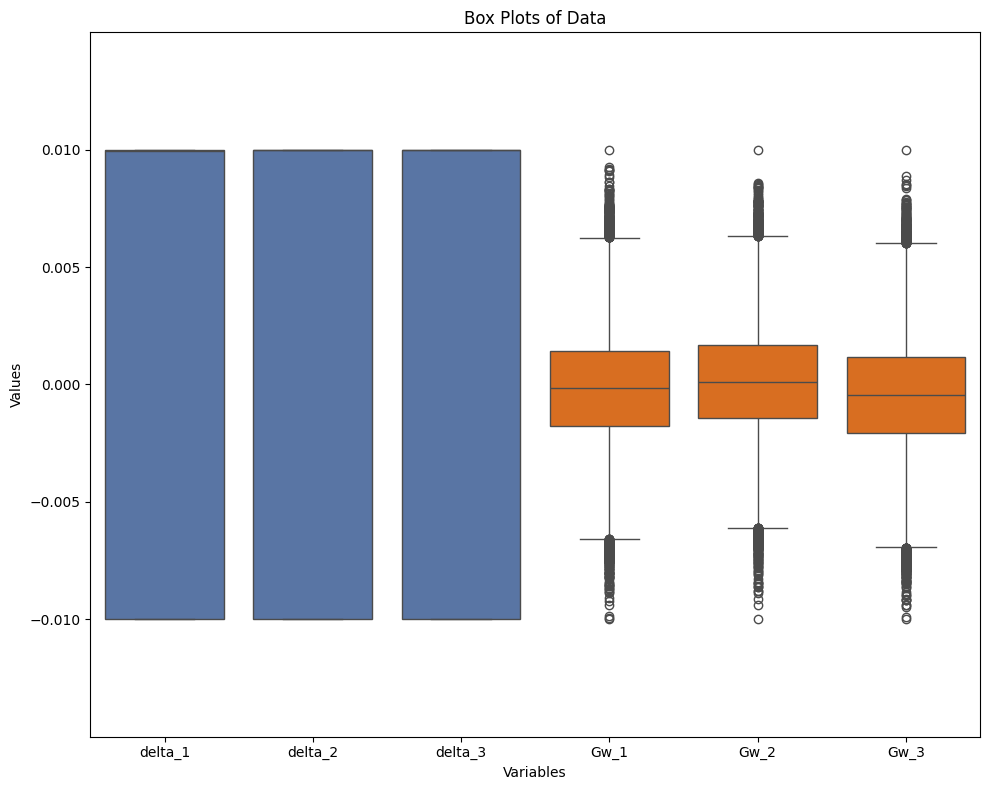

In [145]:
# Melt the DataFrame for easier plotting
df_melted = df.melt(var_name='variable', value_name='value')

orange_hex = '#F76902'
blue_hex = '#4c72b0'
# Set the color palette

keys = df.columns.tolist()
palette = {}
for key in keys:
    if 'Gw' in key:
        palette[key] = orange_hex
    else:
        palette[key] = blue_hex


# Create the box plot
plt.figure(figsize=(10, 8))
sns.boxplot(x='variable', y='value', data=df_melted, palette=palette)

# Customize plot
plt.xticks(rotation=0)
plt.title('Box Plots of Data')
plt.xlabel('Variables')
plt.ylabel('Values')

upper_limit = df.delta_1.max() * 1.5
lower_limit = df.delta_1.min() * (1.5 if df.delta_1.min() < 0 else -1.5)
plt.ylim(lower_limit, upper_limit)

# Show plot
plt.tight_layout()
plt.show()